In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime
import FastQSL

time: 1.11 s (started: 2021-10-20 18:05:16 +08:00)


In [2]:
cupy.__version__

'9.5.0'

time: 0 ns (started: 2021-10-20 18:05:17 +08:00)


In [3]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\fastqsl\lib\site-packages\scipy\io\idl.py:465: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 20 s (started: 2021-10-20 18:05:17 +08:00)


In [4]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False

time: 1.47 s (started: 2021-10-20 18:05:37 +08:00)


In [74]:
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineScott.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")
#print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)
    
dummy=cupy.zeros([1,1],dtype=cupy.float32)
flag_twist=cupy.array([False],dtype=cupy.bool_)

compiling kernel
time: 10.8 s (started: 2021-10-20 20:14:35 +08:00)


In [75]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
BshapeN = cupy.array(BshapeN)

interp_ratio=4
stride_step=1/interp_ratio
# full image
x_range = [0,1163]
y_range = [0,487]
# active region
x_range = [350,670]
y_range = [180,430]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()
z_inp = (cupy.zeros_like(x_inp,cupy.float32)+2# +23.583333
)
#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
    Bx_inp,By_inp,Bz_inp,q_0_gpu,q_perp_gpu
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(11)]
    (flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(2)]
    
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./8.],cupy.float32)
tol_coef = cupy.array([1.],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

# for GTX 1060
# blck=(64,1,1)
# grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)
cupy.cuda.stream.get_current_stream().synchronize()

time: 0 ns (started: 2021-10-20 20:14:46 +08:00)


In [76]:
tol_coef_arr = cupy.array([10**2,10**1.5,10**1.0,10**0.5],dtype=cupy.float32)
#tol_coef_arr = cupy.array([1],dtype=cupy.float32)
Qall_arr=cupy.zeros([*xy_shape,tol_coef_arr.shape[0]],dtype=cupy.float32)

time: 0 ns (started: 2021-10-20 20:14:46 +08:00)


In [77]:
import tqdm
#for idx_tol,real_tol in tqdm.tqdm(enumerate(tol_coef_arr)):

real_tol=tol_coef_arr[3]
if True:
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
    Bx_inp,By_inp,Bz_inp,q_0_gpu,q_perp_gpu
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(11)]
    (flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(2)]
    
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32))
    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                  dummy,dummy,dummy,dummy,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,
                q_0_gpu,q_perp_gpu,
                s_len,N,line_len, real_tol))
    print(x_end)
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr, 
     q_0_gpu_arr, q_perp_gpu_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    q_0_gpu, q_perp_gpu,
                    Bx_inp,By_inp,Bz_inp)
    cupy.cuda.stream.get_current_stream().synchronize()



[350.      350.25018 350.5004  ... 669.49963 669.7498  670.     ]
time: 2.59 s (started: 2021-10-20 20:14:46 +08:00)


In [78]:
q_perp_gpu_arr

array([[ 1.4509383,  3.046573 ,  3.8193462, ..., 13.359249 , 11.320351 ,
        12.241712 ],
       [ 1.9358553,  2.080643 ,  1.6849121, ..., 21.289186 , 16.649803 ,
        18.48186  ],
       [ 2.0548754,  1.4800433,  1.6661165, ..., 21.551552 , 24.670397 ,
        24.644547 ],
       ...,
       [15.15665  , 21.692026 , 36.4082   , ..., 77.3774   , 76.185265 ,
        72.996025 ],
       [ 6.78216  ,  8.667139 , 11.159632 , ..., 73.96399  , 72.132515 ,
        68.95656  ],
       [ 4.996399 ,  5.7489433,  7.062648 , ..., 73.476204 , 69.17404  ,
        64.782684 ]], dtype=float32)

time: 15 ms (started: 2021-10-20 20:14:49 +08:00)


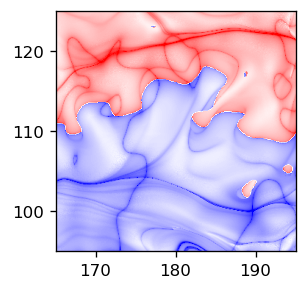

time: 203 ms (started: 2021-10-20 20:16:00 +08:00)


In [82]:
axis_r=0.366
dpi=120


x_range_real = np.array(x_range)*axis_r
y_range_real = np.array(y_range)*axis_r

fig=plt.figure(13,dpi=dpi,figsize=[8,2]);

ax0 = fig.add_axes([0,0,1/4,1])

ax0.imshow(np.log10(q_0_gpu_arr[:,:].get())*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
ax0.set_xlim([165,195])
ax0.set_ylim([95,125])
ax0.axes.get_xaxis().set_ticks([170,180,190])
ax0.axes.get_yaxis().set_ticks([100,110,120])


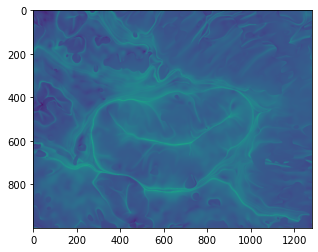

time: 250 ms (started: 2021-10-20 18:46:22 +08:00)


In [13]:
plt.imshow((x_end_arr[:,:].get()))

In [ ]:
plt.imshow(((Qall_arr[:,:,3].get())<1.000001),#*np.sign(Bz_0_arr.get()),
                cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
plt.gca().set_xlim([165,195])
plt.gca().set_ylim([95,125])

In [ ]:
np.where(np.isnan(Qall_arr[:,:,3].get()))

array(-65.21135, dtype=float32)

time: 484 ms (started: 2021-10-20 18:15:22 +08:00)
